# 🔧 Fine-Tuning a Machine Learning Model

In this workshop, we will learn how to fine-tune machine learning models using the Wine Quality dataset. We'll explore the impact of different hyperparameters on model performance using tools like Grid Search and Randomized Search.

We'll walk through:

- Loading and exploring the dataset
- Building a baseline model
- Understanding hyperparameters
- Fine-tuning the model using `GridSearchCV` and `RandomizedSearchCV`
- Evaluating the tuned model


In [1]:
import pandas as pd

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 📊 About the Dataset

This dataset contains information about different physicochemical tests performed on red wine samples. The target variable is `quality`, which scores wine on a scale of 0 to 10.

Let's explore the basic structure and check for missing values.

In [2]:
data.info()
data.describe()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


## 🔍 Preprocessing

- We'll separate features and the target
- We'll split the dataset into training and testing sets
- Since Random Forests aren't sensitive to feature scaling, we’ll skip that here

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('quality', axis=1)
y = data['quality']

# Simplify the problem: group into binary classification (quality ≥ 7 is good wine)
y = (y >= 7).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 🛠️ Baseline Model

Let’s train a basic Random Forest model to establish a baseline performance.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.94375
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       277
           1       0.93      0.63      0.75        43

    accuracy                           0.94       320
   macro avg       0.94      0.81      0.86       320
weighted avg       0.94      0.94      0.94       320



## 🎛️ Fine-Tuning with Grid Search

Grid Search tries all combinations of given hyperparameter values using cross-validation. It’s exhaustive but can be slow for large search spaces.

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Val Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Val Score: 0.8999295343137256


## 🌀 Fine-Tuning with Randomized Search

Randomized Search samples a fixed number of parameter combinations randomly. It’s faster for large search spaces.

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best Parameters (Randomized Search):", random_search.best_params_)
print("Best Cross-Val Score:", random_search.best_score_)

Best Parameters (Randomized Search): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 263}
Best Cross-Val Score: 0.8905484068627452


## 📈 Evaluating the Tuned Model

Now we’ll evaluate the best model from Grid Search on the test set.

In [7]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.940625
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       277
           1       0.93      0.60      0.73        43

    accuracy                           0.94       320
   macro avg       0.94      0.80      0.85       320
weighted avg       0.94      0.94      0.94       320



## 🔍 Feature Importance

Which features contributed most to the predictions?

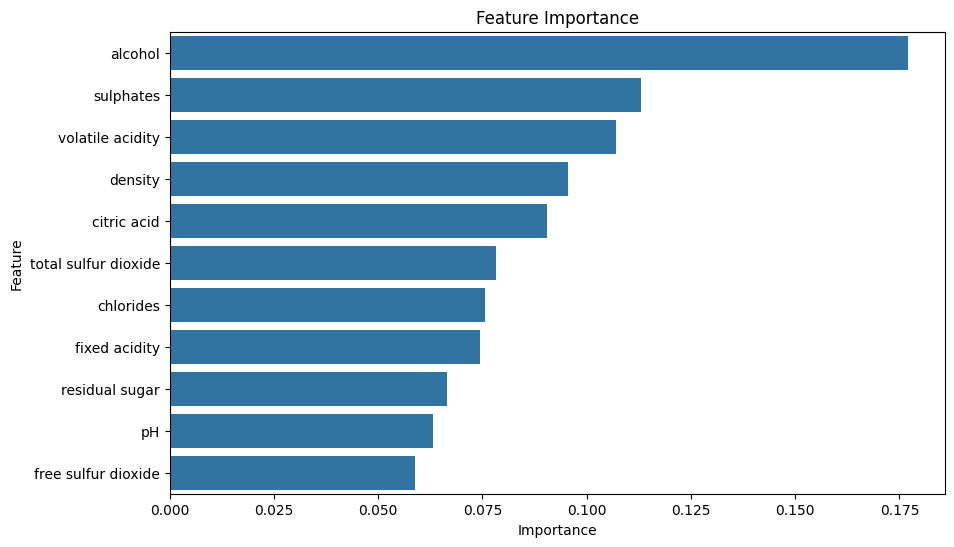

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance')
plt.show()

# ✅ Summary

- A baseline model gives us a starting point.
- Hyperparameter tuning with `GridSearchCV` and `RandomizedSearchCV` can significantly improve performance.
- Random Forest has multiple tunable parameters like `n_estimators`, `max_depth`, and `max_features`.
- Visualizing feature importance helps us interpret the model.